In [1819]:
import math
import random
import numpy as np
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [1820]:
DATASETS_DIR = "datasets"

TRAIN_PATH = pl.Path(f"{DATASETS_DIR}/train.csv");
TEST_PATH = pl.Path(f"{DATASETS_DIR}/test_features.csv");
SUBMISSION_PATH = pl.Path(f"{DATASETS_DIR}/sample_submission.csv");

In [1821]:
df = pd.read_csv(TRAIN_PATH)

### Analysing data from the available dataset

In [1822]:
df

,Sex,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
0,M,0.725,0.550,0.200,1.5100,0.8735,0.4265,0.5085,9
1,F,0.415,0.340,0.130,0.3675,0.1460,0.0885,0.1200,10
2,M,0.705,0.555,0.215,2.1410,1.0465,0.3830,0.5280,11
3,I,0.375,0.290,0.095,0.2875,0.1230,0.0605,0.0800,6
4,F,0.680,0.500,0.185,1.7410,0.7665,0.3255,0.4685,12
...,...,...,...,...,...,...,...,...,...
3131,F,0.575,0.480,0.165,1.0780,0.5110,0.2095,0.3060,9
3132,M,0.585,0.455,0.125,1.0270,0.3910,0.2120,0.2500,17
3133,I,0.395,0.270,0.100,0.2985,0.1445,0.0610,0.0820,5
3134,M,0.415,0.305,0.100,0.3250,0.1560,0.0505,0.0910,6


In [1823]:
df.describe()

,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
count,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000
mean,0.524141,0.407868,0.139115,0.829300,0.359130,0.180738,0.239251,9.948023
std,0.120807,0.099984,0.039111,0.492789,0.222860,0.110205,0.139756,3.290532
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.348750,0.115000,0.440500,0.184375,0.092875,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.801000,0.336000,0.171000,0.234500,9.000000
75%,0.615000,0.480000,0.165000,1.156500,0.503625,0.254000,0.330000,11.000000
max,0.815000,0.650000,0.515000,2.825500,1.488000,0.760000,0.897000,29.000000


In [1824]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       3136 non-null   object 
 1   Length    3136 non-null   float64
 2   Diameter  3136 non-null   float64
 3   Height    3136 non-null   float64
 4   weight_1  3136 non-null   float64
 5   weight_2  3136 non-null   float64
 6   weight_3  3136 non-null   float64
 7   weight_4  3136 non-null   float64
 8   target    3136 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 220.6+ KB


### Data preprocessing step

In [1825]:
df = pd.get_dummies(df, columns=["Sex"])
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

### Feature selection

In [1826]:
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)

### Building model step

#### LogisticRegression
##### Without StandardScaler:
Average RMSE: 2.8802295489774763<br/>
Average accuracy: 25.339702760084926%

##### With StandardScaler:
Average RMSE: 2.514089326176255<br/>
Average accuracy: 26.698513800424628%

#### SVM
##### Without StandardScaler:
Average RMSE: 2.9862460682467136<br/>
Average accuracy: 24.278131634819538%

##### With StandardScaler:
Average RMSE: 2.760371805082272<br/>
Average accuracy: 26.11464968152866%

In [1827]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

models = [SVC(kernel='poly'), SVC(kernel='linear'), LogisticRegression(), DecisionTreeClassifier()]
ss = StandardScaler()

verbose = False
experiments = 15
avg_accuracies = []
avg_rmses      = []

for model in models:
    print(f"Analysing {type(model).__name__}")
    
    avg_rmse = 0
    avg_accuracy = 0
    
    for experiment in range(experiments):
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))

        y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
        y_test, X_test = test_df['target'], test_df.drop('target', axis=1)

        X_train = ss.fit_transform(X_train)
        X_test = ss.fit_transform(X_test)

        best_model = None
        min_rmse, max_accuracy = +math.inf, -math.inf

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        avg_rmse += rmse
        if min_rmse > rmse:
            min_rmse = rmse
        if verbose:
            print(f"RMSE in experiment {experiment + 1}: {rmse}")

        accuracy = model.score(X_test, y_test)
        avg_accuracy += accuracy
        if max_accuracy < accuracy:
            max_accuracy = accuracy
        if verbose:
            print(f"Accuracy in experiment {experiment + 1}: {accuracy * 100}%")

    avg_rmse /= experiments
    avg_rmses.append(avg_rmse)
    print(f"Average RMSE: {avg_rmse}")
    
    avg_accuracy /= experiments
    avg_accuracies.append(avg_accuracy)
    print(f"Average accuracy: {avg_accuracy * 100}%")
    
best_model = None 
best_rmse, best_accuracy = +math.inf, -math.inf

for model, avg_rmse, avg_accuracy in zip(models, avg_rmses, avg_accuracies):
    # if best_rmse > avg_rmse and best_accuracy < avg_accuracy:
    if best_accuracy < avg_accuracy:
        best_rmse = avg_rmse
        best_accuracy = avg_accuracy
        best_model = model

Analysing SVC
Average RMSE: 2.440857963195909
Average accuracy: 26.203090507726273%
Analysing SVC
Average RMSE: 2.4202097132947364
Average accuracy: 26.754966887417215%
Analysing LogisticRegression


/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documenta

Average RMSE: 2.246011143715642
Average accuracy: 26.898454746136867%
Analysing LinearRegression
Average RMSE: 186865085027.91763
Average accuracy: -2.583876636068502e+24%
Analysing DecisionTreeClassifier
Average RMSE: 2.6683634228426607
Average accuracy: 20.5849889624724%


In [1828]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = df["target"].unique() # name of classes

Text(0.5, 427.9555555555555, 'Predicted label')

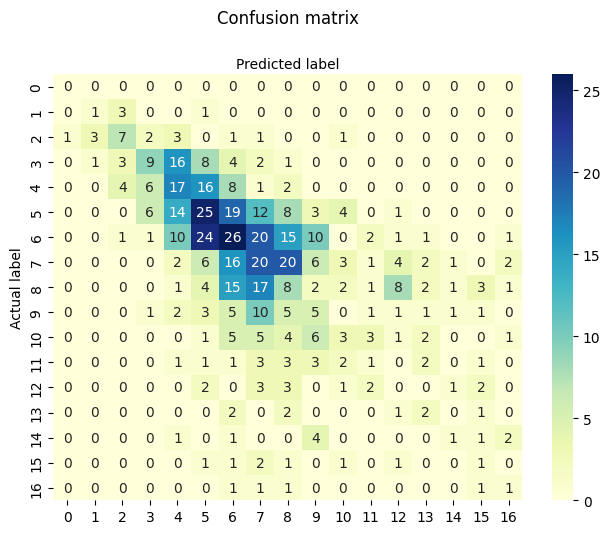

In [1829]:
# configure heatmap
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [1830]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.20      0.20      0.20         5
           5       0.39      0.37      0.38        19
           6       0.36      0.20      0.26        44
           7       0.25      0.31      0.28        54
           8       0.27      0.27      0.27        92
           9       0.25      0.23      0.24       112
          10       0.21      0.24      0.22        83
          11       0.11      0.12      0.12        65
          12       0.13      0.14      0.13        36
          13       0.18      0.10      0.12        31
          14       0.09      0.06      0.07        18
          15       0.00      0.00      0.00        14
          16       0.17      0.25      0.20         8
          17       0.20      0.10      0.13        10
          18       0.09      0.12      0.11         8
          19       0.12      0.20      0.15         5

    accuracy              

/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples

### Trying model with test data

In [1831]:
df = pd.read_csv(TEST_PATH)

In [1832]:
df = pd.get_dummies(df, columns=["Sex"])

In [1833]:
df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)

In [1834]:
X_output = ss.fit_transform(df)
y_output = best_model.predict(X_output)

### Publishing test output to sample submission file

In [1835]:
df = pd.read_csv(SUBMISSION_PATH)
df['target'] = y_output

In [1836]:
df.to_csv(SUBMISSION_PATH)